## Twitter Data Exploration

### Import all the datasets

In [1]:
# the regulars
import pandas as pd
import numpy as np
import plotly.express as px
import osmnx as ox
import matplotlib.pyplot as plt

# to get tweets
import tweepy as tw

# for sentiment analysis
from textblob import TextBlob
import re

# word clouds
from wordcloud import WordCloud, STOPWORDS

### Extract data from Twitter

In [2]:
consumer_key= 'ip8ImxEEMyx3vIpexjrSyd7lQ'
consumer_secret= '8dYRy7fH3DLFnyX0HMR22aLd9KkzOboEzPTudtWMakZfJv29Ms'
access_token= '1362022016581136393-q0muzatYaslijcmrw539Ck5PnRIvNM'
access_token_secret= '19YNw7CwCSUcjuaJ2kxdUniXzVPpTRckuUkY5kBIta7gK'

In [3]:
# authenticate thyself with twitter
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

### Create a function to clean the tweets of unwanted symbols

In [8]:
# function to clean tweets using regular expressions
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", tweet).split())

### Create function to generate data and visualization based on different locations/keywords

In [53]:
def find_tweets(q,geocode= None,count=500):
    
    #
    # grab the tweets
    #
    
    tweets = tw.Cursor(api.search,
                       q=q+' (-filter:retweets) lang:en', # no retweets 
                       geocode = geocode,
                       tweet_mode='extended').items(count)
    #
    # create a dataframe
    #
    
    json_data = [tweet._json for tweet in tweets]
    df = pd.json_normalize(json_data)

    # clean it up
    df = df[['created_at','full_text']]

    # clean the text
    df['clean_text'] = ''
    
    for i, row in df.iterrows():
        clean = clean_tweet(row.full_text)
        df.at[i,'clean_text'] = clean

    #
    # word cloud
    #
    
    # put every tweet in a single variable
    all_text = ' '.join(df['clean_text'])
    
    # Create stop words
    stop_words = searchterm + list(STOPWORDS)
    
    # create the word cloud
    wordcloud = WordCloud(width=1200, 
                          height=800,
                          background_color="white",
                          stopwords=stop_words).generate(all_text)

    # Display the WordCloud                    
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    #
    # sentiment analysis
    #
    
    df['polarity']=''
    
    # add polarity index to each tweet
    for i, row in df.iterrows():
        a = TextBlob(row.full_text)
        df.at[i,'polarity'] = a.polarity
    
    # create a list of our conditions
    conditions = [
        (df['polarity'] < -0.2), # very negative
        (df['polarity'] < 0) & (df['polarity'] >= -0.2),   # negative
        (df['polarity'] == 0),  # neutral
        (df['polarity'] > 0) & (df['polarity'] <= 0.2),    # positive
        (df['polarity'] > 0.2)  # very positive
        ]

    # create a list of the values we want to assign for each condition
    values = [
        'very negative', 
        'negative', 
        'neutral', 
        'positive',
        'very positive'
        ]

    # create a new column and use np.select to assign values to it using our lists as arguments
    df['sentiment'] = np.select(conditions, values)

    #
    # Sentiment bar chart
    #
    
    # bar chart
    fig = px.bar(df, 
                 x='sentiment',
                 width=600,
                 title='Sentiment analysis for "'+ q + '"',
                 color='sentiment',
                 category_orders = {'sentiment':['very negative','negative','neutral','positive','very positive']},
                 color_discrete_sequence=sentiment_colors, # use the colors selected in previous cell
                )
    # fig.update_traces(textinfo='value')
    fig.update_traces(marker_line_width=0) # gets rid of horizontal white lines
    fig.show()

    #
    # histogram
    # 
    
    num_bins = 50
    plt.figure(figsize=(10,6))
    n, bins, patches = plt.hist(df.polarity, num_bins, facecolor='blue', alpha=0.5)
    plt.xlabel('Polarity')
    plt.ylabel('Count')
    plt.title('Histogram of polarity for "' + q + '"')

    plt.axvline(df.polarity.mean(), color='k', linestyle='dashed', linewidth=1)

    min_ylim, max_ylim = plt.ylim()
    plt.text(df.polarity.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df.polarity.mean()))

    plt.show()

    #
    # Show top 10 and bottom 10 tweets
    #
    
    top10 = df.sort_values('polarity').head(10)[['clean_text','polarity']]
    bottom10 = df.sort_values('polarity').tail(10)[['clean_text','polarity']]
    
    display('Top 10 negative tweets')
    display(top10)
    
    display('Top 10 positive tweets')
    display(bottom10)

### Define the keywords

In [59]:
q = "('coral reef' OR 'coral reefs')"
searchterm = ['coral reef','coral reefs','coral','corals','reef','reefs','coralreef','coralreefs','4K']

I used `coral reef` and `coral reefs` instead of just `coral` or `corals` because there are a lot of usernames that contain 'coral', which can be misleading.
`searchterm` is set to contain all the words that are similar to the keyword or the words that are confusing. 

### Set the colors for the visualization

In [60]:
sentiment_colors = ox.plot.get_colors(5,cmap='PiYG',return_hex=True)

### Apply function to first examine global-scale tweets about coral reefs

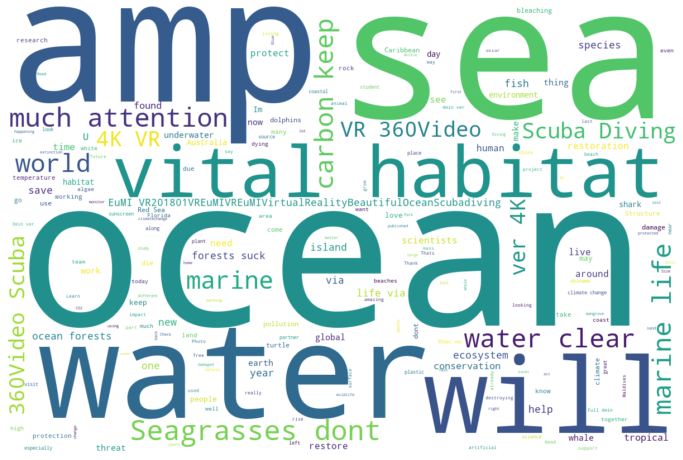

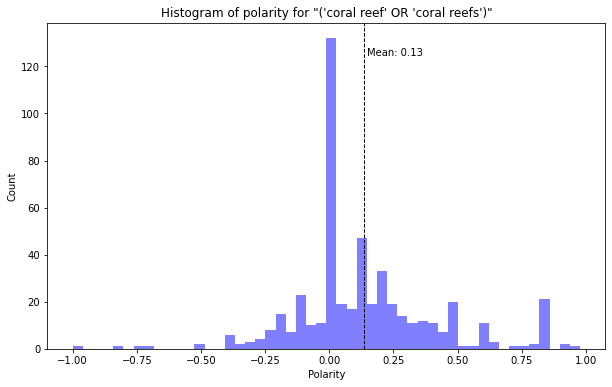

'Top 10 negative tweets'

,clean_text,polarity
488,I scanned disgusting coral beep reefs boop on ...,-1
89,Omg just listened to Johan Rockstrom saying pr...,-0.805
278,damn we gotta save our coral reefs climatechange,-0.75
417,i wanna be by the coral reefs and stuff in the...,-0.7
470,Galileo discovered Mars in 1610 Moon rock came...,-0.5
15,of putting man made structures in South China ...,-0.5
231,Oh go on thenSea levels rise at about 200mm pe...,-0.4
400,The impact to the coral reefs is awful The who...,-0.4
401,The impact to the coral reefs is awful The who...,-0.4
159,Due to global warming and pollution coral reef...,-0.375


'Top 10 positive tweets'

,clean_text,polarity
35,30sec ver 4K VR 360Video Scuba Diving Coral re...,0.85
257,3min ver 4K VR 360Video Scuba Diving Coral ree...,0.85
107,30sec ver 4K VR 360Video Scuba Diving Coral re...,0.85
102,90sec ver 4K VR 360Video Scuba Diving Coral re...,0.85
347,30sec ver 4K VR 360Video Scuba Diving Coral re...,0.85
343,90sec ver 4K VR 360Video Scuba Diving Coral re...,0.85
263,30sec ver 4K VR 360Video Scuba Diving Coral re...,0.85
23,when you save the coral reefs on the gold coas...,0.9
90,A brilliant discovery could help coral reefs t...,0.9
452,Congrats reefs need more people like you,0.976562


In [56]:
find_tweets(q)

From the above wordCloud, we can see that the words that appear the most often are words such as `ocean`, `sea`, `water`, and `vital habitat`. It is visually very difficult to find the word `bleaching` on this image, which could potentially suggest that people have a limited awareness about the issue of coral bleaching or that this issue is not being discussed enough. 

We can find small words such as `climate change`, `white`, `conservation`. These are words related to coral bleahcing, but they do not seem to come up very often. This, again, could mean that the public might not be as familiar with the process of coral bleaching. 

Judging from the sentiment analysis, it seems that the average sentiment is more on the positive side. However, looking at the top 10 positive tweets, a lot of them are similar tweets about high-quality coral reef videos. The sentiment analysis can therefore not be trusted too much. In the top 10 negative tweets, we can find that some people are commenting on the negatvie impact on corals, which potentially means that the tweets marked as "negative" contain the ones that talk about threats to corals. 

### Do another test around the Caribbean region

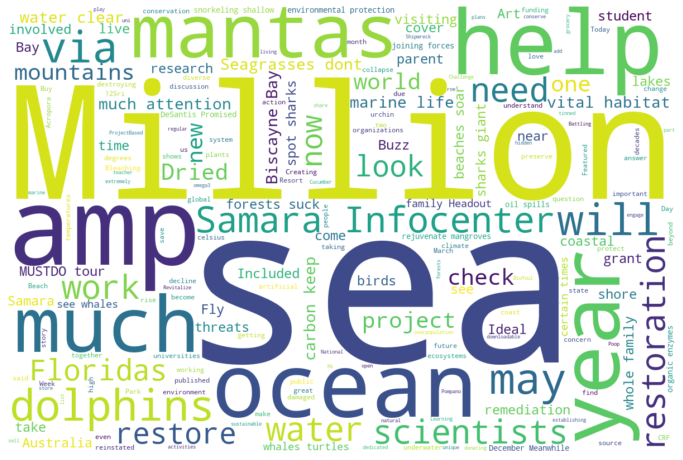

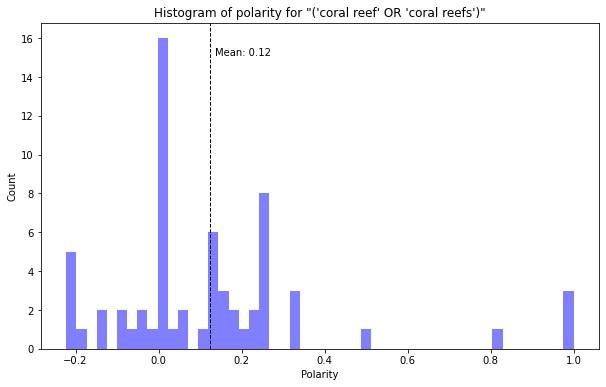

'Top 10 negative tweets'

,clean_text,polarity
60,check it Two heavy hitters amp joining forces ...,-0.222222
17,It takes a village to restore coral reefs We w...,-0.21875
43,DeSantis Promised 10 Million For Biscayne Bay ...,-0.2
51,DeSantis Promised 10 Million For Biscayne Bay ...,-0.2
49,DeSantis Promised 10 Million For Biscayne Bay ...,-0.2
8,Here is an oped on coral reefs published in th...,-0.181818
55,Weve increased global temperatures by 15 degre...,-0.1275
6,Having siblings means still doing presentation...,-0.125
44,Ten million dollars will come from the state a...,-0.1
12,Ocean warming threatens coral reefs and soon c...,-0.1


'Top 10 positive tweets'

,clean_text,polarity
57,Coral reefs can become damaged permanently so ...,0.25
29,23 The old photo shows remarkably high coral c...,0.253333
15,This is a MUSTDO tour when visiting Samara Fly...,0.325
34,This is a MUSTDO tour when visiting Samara Fly...,0.325
7,This is a MUSTDO tour when visiting Samara Fly...,0.325
53,Our planet is dying animals are vanishing the ...,0.5
62,hey buddy check it NSU and CRF joining forces ...,0.8125
25,Congrats reefs need more people like you,0.976562
46,Listen to s excellent story about conservation...,1
32,WaterMattersDay is now WaterMattersMonth Week ...,1


In [62]:
find_tweets(q,geocode='15.639370,-75.283807,2000km')

In the Caribbean region, we seem to see larger words about things related to restoration and conservation, which could possibly explain how there is a decrease in coral bleaching severity in some Caribbean regions in the data exploration I carried out before – people here might be more conscious about coral proteciton. 

In the sentiment analysis, we can see that the most positive ones are often about tourism, which corresponds to the many region names that appear in the wordCloud. The negative ones, similar to the global analyhsis, shows people who are aware of threats to corals.

### Do another analysis around Indonesia and surrounding countries

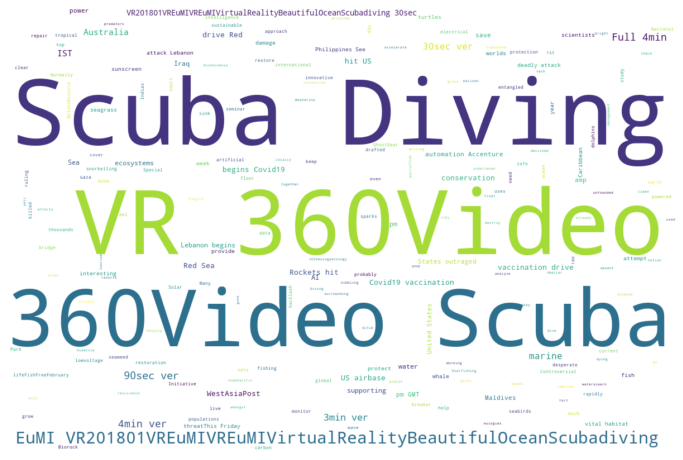

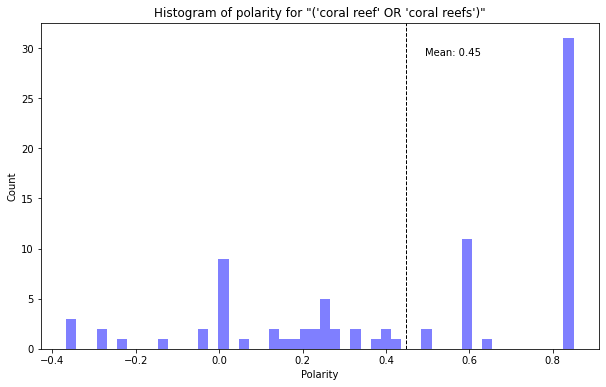

'Top 10 negative tweets'

,clean_text,polarity
73,This week on The WestAsiaPost with Rockets hit...,-0.366667
70,This week on The WestAsiaPost with Rockets hit...,-0.366667
54,Tonight on The WestAsiaPost with Rockets hit U...,-0.366667
19,Special artificial intelligence is drafted in ...,-0.280952
65,Special artificial intelligence is drafted in ...,-0.280952
52,LIVE On The WestAsiaPost with Rockets hit US a...,-0.240909
84,With all due respect Sendi how is seaweed a wa...,-0.125
51,Not only are thousands of whales dolphins turt...,-0.0333333
16,Not only are thousands of whales dolphins turt...,-0.0333333
8,AI attempt to save Australias dying coral reefs,0


'Top 10 positive tweets'

,clean_text,polarity
67,90sec ver 4K VR 360Video Scuba Diving Coral re...,0.85
56,90sec ver 4K VR 360Video Scuba Diving Coral re...,0.85
5,3min ver 4K VR 360Video Scuba Diving Coral ree...,0.85
14,90sec ver 4K VR 360Video Scuba Diving Coral re...,0.85
38,30sec ver 4K VR 360Video Scuba Diving Coral re...,0.85
36,90sec ver 4K VR 360Video Scuba Diving Coral re...,0.85
35,3min ver 4K VR 360Video Scuba Diving Coral ree...,0.85
4,30sec ver 4K VR 360Video Scuba Diving Coral re...,0.85
57,30sec ver 4K VR 360Video Scuba Diving Coral re...,0.85
20,90sec ver 4K VR 360Video Scuba Diving Coral re...,0.85


In [61]:
find_tweets(q,geocode='2.512251,126.173008,5000km')

The WordCloud in Indonesia shows overwhelming focus on scuba diving and videos. While words like `conservation` are still visible, they become much smaller. This suggests that Indonesia and nearby SE Asian countries have a much larger focus on tourism than Caribbean countries. 

The sentiment analysis also shows a very large portion of tweets marked as 'very positive', and the top 10 are all videos of scuba diving. This potentially means that tourism in these areas outweigh the importance of coral protection. 

## Conclusion

Based on the above analysis, I think it would be very interesting if my next step focuses on more specific regions. Since I have already created a timeline that shows the change in coral bleaching across time, it will be interesting to do a Twitter analysis on the areas that have seen a siginificant increase/decrease in coral bleaching severity. In a way, Twitter reflects public consciousness, and my next step would be to find if public consciousness is correlated with coral protection/damage. 